# Multi-energy generation systems - Example with cogeneration

***&copy; 2021 Martínez Ceseña<sup>1</sup> and Mancarella<sup>2</sup> — <sup>1,2</sup>University of Manchester, UK, and <sup>2</sup>University of Melbourne, Australia***

This is one of the documents in a series of jupyter notebooks which presents a general formulation to optimise the operation of centralised multi-energy systems (MES). The optimisation models provide time series (e.g., series of hourly periods) with the optimal set points of distributed energy resources (DER) and imports and exports from different networks required to meet energy demand (e.g., electricity, heat and gas). The specific models presented here are based on the following literature:

1. E. A. Martínez Ceseña, T. Capuder and P. Mancarella, “[Flexible distributed multi-energy generation system expansion planning under uncertainty](https://ieeexplore.ieee.org/document/7064771),” IEEE Transactions on Smart Grid, Vol. 7, pp. 348 –357, 2016.

1. T. Capuder, P. Mancarella, "[Techno-economic and environmental modelling and optimization of flexible distributed multi-generation options](https://www.sciencedirect.com/science/article/pii/S0360544214005283)," Energy, Vol. 71, pp. 516-533, 2014.

1. E. A. Martínez Ceseña, E. Loukarakis, N. Good and P. Mancarella, "[Integrated Electricity-Heat-Gas Systems: Techno-Economic Modeling, Optimization, and Application to Multienergy Districts](https://ieeexplore.ieee.org/document/9108286)," in Proceedings of the IEEE, Vol. 108, pp. 1392 –1410, 2020.

1. G. Chicco, S. Riaz, A. Mazza and P. Mancarella, "[Flexibility From Distributed Multienergy Systems](https://ieeexplore.ieee.org/document/9082595)," in Proceedings of the IEEE, Vol. 108, pp. 1496-1517, 2020.

1. E. Corsetti, S. Riaz, M. Riello, P. Mancarella, “[Modelling and deploying multi-energy flexibility: The energy lattice framework](https://www.sciencedirect.com/science/article/pii/S2666792421000238)”, Advances in Applied Energy, Vol. 2, 2021.

This particular notebook provides a linear programming (LP) formulation of a flexible MES which includes multiple interconnected DER, including cogeneration.

## List of contents

- [Before we begin](#Before-we-begin)
- [MES model settings](#MES-model-settings)
- [DER](#DER)
  - [Boiler model](#Boiler-model)
  - [EHP](#EHP)
  - [CHP](#CHP)
- [Energy balance](#Energy-balance)
  - [Electricity-balance](#Electricity-balance)
  - [Gas balance](#Gas-balance)
  - [Heat balance](#Heat-balance)
- [Objective-function](#Objective-function)
- [Visualization](#Visualization)
  - [Bar plot](#Bar-plot)
  - [Sankey diagram](#Sankey-diagram)
  - [Flexibility area](#Flexibility-area)
- [Case studies](#Case-studies)
  - [Summary of the MES formulation](#Summary-of-the-MES-formulation)
  - [Example](#Example)

[Back to top](#Multi-energy-generation-systems---Example-with-tri-generation)

## Before we begin

Before we begin, be aware that, to benefit the most from this notebook, you will need a basic understanding of: 
- [Linear programming](https://realpython.com/linear-programming-python/) (LP) models, which are the types of models presented below.
- [Python](https://www.python.org/), which is the language used in this notebook.
- The [pyomo](https://pyomo.readthedocs.io/en/stable/index.html) library, which is the optimisation software used to solve the examples in this notebook.

This notebook also requires some of the equations defined in a previous jupyter notebook: *Multi-energy generation systems - Example with gas boiler*, i.e., the gas boiler model.

To import these equations, we will use the `nbimporter` library which allow us to load methods from jupyter notebooks. The commands used to load the boiler model are presented below.

In [1]:
!pip install nbimporter
import nbimporter

def add_Boiler(model):
    mes = __import__('Multi-energy generation systems - Example with gas boiler')
    return mes.add_Boiler(model)

You should consider upgrading via the 'c:\users\mbbx6ng3\anaconda3\python.exe -m pip install --upgrade pip' command.


[Back to top](#Multi-energy-generation-systems---Example-with-cogeneration)

## MES model settings

This time we will model a more complex MES, which is shown in **Figure 1**:

![MES_cogeneration.png](Figures/MES_cogeneration.png)
<center><b>Figure 1. </b>Flow diagram of a MES with cogeneration.</center>

As shown in the figure, the MES includes:
- **Combined heat and power (CHP)**: This unit consumes gas to produce electricity and heat
- **Electric heat pump (EHP)**: This model is based on a simplified representation of air-source heat pumps which consume electricity to produce heat
- **Gas boiler**: This DER was introduced in a previous notebook. It consumes gas to produce heat
- **Energy Spill** and **load shedding**: These options increase the flexibility of the MES.

To begin developing the model, and optimisation mathematical programming model (in `pyomo`) is defined. In this notebook, the pyomo object is named `pyo`, whereas the mathematical programming model is named `model`.

In [2]:
import pyomo.environ as pyo
model = pyo.ConcreteModel()

In this example, the model will be illustrated with a case study considering three periods. Other numbers of periods can be considered as long as the number of periods in the relevant input parameters matches.

In [3]:
model.Set_Periods = range(3)

[Back to top](#Multi-energy-generation-systems---Example-with-cogeneration)

## DER

### Boiler model

The gas boiler model used in *Multi-energy generation systems - Example with gas boiler* will also be used in this notebook. The DER is highlighted in the **Figure 2**.

![MES_cogeneration_Focus_Boiler.png](Figures/MES_cogeneration_Focus_Boiler.png)
<center><b>Figure 2. </b>Flow diagram of a MES with cogeneration - Focus on gas boiler.</center>

The gas boiler equations are presented below.

$$
Boiler \_ Heat \_ Output_{period} \leq Boiler \_ Heat \_ Capacity
$$

$$
Boiler \_ Heat \_ Output_{period} = Boiler \_ Gas \_ Input_{period} \times Boiler \_ Heat \_ Efficiency_{period}
$$

The parameters (capacity and efficiency) should be defined, so that we can customise them in the case studies presented in this notebook.

In [4]:
model.Boiler_Heat_Capacity = 5  # [kW]
model.Boiler_Heat_Efficiency = 0.85  # [pu]

That said, rather than coding the constraints again, we can import them from the previous notebook.

In [5]:
add_Boiler(model)

[Back to top](#Multi-energy-generation-systems---Example-with-cogeneration)

### EHP

Next, we will introduce the EHP model, which is shown in **Figure 3**.

![MES_cogeneration_Focus_EHP.png](Figures/MES_cogeneration_Focus_EHP.png)
<center><b>Figure 3. </b>Flow diagram of a MES with cogeneration - Focus on EHP.</center>

The equations used to model the operation and capacity limits of EHP are presented below.

$$
EHP \_ Electricity \_ Output_{period} \leq EHP \_ Heat \_ Capacity
$$

$$
EHP \_ Heat \_ Output_{period} = EHP \_ Electricity \_ Input_{period} \times EHP \_ Efficiency_{period}
$$

The equations include two parameters, namely the coefficient of performance (i.e., the efficiency of the devices) and capacity.

In [6]:
model.EHP_Heat_Capacity = 5  # [kW]
model.EHP_Heat_Efficiency = 3  # [pu]

Two variables are also needed to model the equations: the electricity import and thermal output of the devices.

In [7]:
model.EHP_Electricity_Input = pyo.Var(model.Set_Periods,
                                      domain=pyo.NonNegativeReals)
model.EHP_Heat_Output = pyo.Var(model.Set_Periods,
                                domain=pyo.NonNegativeReals)

The following code is used to code the constraints using the parameters and constraints that were just created.

In [8]:
def EHP_Capacity_rule(model, period):
    return model.EHP_Heat_Output[period] <= \
        model.EHP_Heat_Capacity


def EHP_Output_rule(model, period):
    return model.EHP_Heat_Output[period] == \
        model.EHP_Electricity_Input[period] * \
        model.EHP_Heat_Efficiency

model.Constraint_EHP_Capacity = pyo.Constraint(model.Set_Periods,
                                               rule=EHP_Capacity_rule)
model.Constraint_EHP_Operation = pyo.Constraint(model.Set_Periods,
                                                rule=EHP_Output_rule)

For the sake of convenience, the following method is used to add the EHP variables and constraints to an optimisation model.

In [9]:
def add_EHP(model):
    model.EHP_Electricity_Input = pyo.Var(model.Set_Periods,
                                          domain=pyo.NonNegativeReals)
    model.EHP_Heat_Output = pyo.Var(model.Set_Periods,
                                    domain=pyo.NonNegativeReals)
    model.Constraint_EHP_Capacity = pyo.Constraint(model.Set_Periods,
                                                   rule=EHP_Capacity_rule)
    model.Constraint_EHP_Operation = pyo.Constraint(model.Set_Periods,
                                                    rule=EHP_Output_rule)

[Back to top](#Multi-energy-generation-systems---Example-with-cogeneration)

### CHP

The last DER to be added to the model is the CHP unit, which is highlighted in **Figure 4**.

![MES_cogeneration_Focus_CHP.png](Figures/MES_cogeneration_Focus_CHP.png)
<center><b>Figure 4. </b>Flow diagram of a MES with cogeneration - Focus on CHP.</center>

The constraints used to model the capacity and operation of the CHP unit are presented below.

$$
CHP \_ Heat \_ Output_{period} \leq CHP \_ Heat \_ Capacity_{period}
$$
$$
CHP \_ Electricity \_ Output_{period} = CHP \_ Gas \_ Input_{period} \times CHP \_ Electricity \_ Efficiency_{period}
$$
$$
CHP \_ Heat \_ Output_{period} = CHP \_ Gas \_ Input_{period} \times CHP \_ Heat \_ Efficiency_{period}
$$

The parameters to model the CHP unit include the capacity and the electricity and heat efficiencies of the unit.

In [10]:
model.CHP_Heat_Capacity = 5  # [kW]
model.CHP_Electricity_Efficiency = 0.35  # [pu]
model.CHP_Heat_Efficiency = 0.45  # [pu]

The variables required to model the CHP units include the gas inputs, and electricity and heat outputs of the units.

In [11]:
model.CHP_Gas_Input = pyo.Var(model.Set_Periods,
                              domain=pyo.NonNegativeReals)
model.CHP_Electricity_Output = pyo.Var(model.Set_Periods,
                                       domain=pyo.NonNegativeReals)
model.CHP_Heat_Output = pyo.Var(model.Set_Periods,
                                domain=pyo.NonNegativeReals)

Now that the parameters and variables have been defined, the CHP constraints can be coded with the following methods:

In [12]:
def CHP_Capacity_rule(model, period):
    return model.CHP_Heat_Output[period] <= model.CHP_Heat_Capacity

def CHP_Electricity_Output_rule(model, period):
    return model.CHP_Electricity_Output[period] == \
        model.CHP_Gas_Input[period] * model.CHP_Electricity_Efficiency

def CHP_Heat_Output_rule(model, period):
    return model.CHP_Heat_Output[period] == \
        model.CHP_Gas_Input[period] * model.CHP_Heat_Efficiency

model.Constraint_CHP_Capacity = pyo.Constraint(model.Set_Periods,
                                               rule=CHP_Capacity_rule)
model.Constraint_CHP_Electricity_Operation = \
    pyo.Constraint(model.Set_Periods, rule=CHP_Electricity_Output_rule)
model.Constraint_CHP_Heat_Operation = \
    pyo.Constraint(model.Set_Periods, rule=CHP_Heat_Output_rule)

For the sake of convenience, the following method is created to consolidate the methods required to produce the CHP model.

In [13]:
def add_CHP(model):
    model.CHP_Gas_Input = pyo.Var(model.Set_Periods,
                                  domain=pyo.NonNegativeReals)
    model.CHP_Electricity_Output = pyo.Var(model.Set_Periods,
                                           domain=pyo.NonNegativeReals)
    model.CHP_Heat_Output = pyo.Var(model.Set_Periods,
                                    domain=pyo.NonNegativeReals)
    model.Constraint_CHP_Capacity = \
        pyo.Constraint(model.Set_Periods, rule=CHP_Capacity_rule)
    model.Constraint_CHP_Electricity_Operation = \
        pyo.Constraint(model.Set_Periods, rule=CHP_Electricity_Output_rule)
    model.Constraint_CHP_Heat_Operation = \
        pyo.Constraint(model.Set_Periods, rule=CHP_Heat_Output_rule)

[Back to top](#Multi-energy-generation-systems---Example-with-cogeneration)

## Energy balance

### Electricity balance

Electricity balance is modelled considering the energy flows and components presented in the next figure.

![MES_cogeneration_Focus_Electricity.png](Figures/MES_cogeneration_Focus_Electricity.png)
<center><b>Figure 5. </b>Flow diagram of a MES with cogeneration - Electricity balance.</center>

As can be deduced from the figure the CHP provides the MES with flexibility to export power back to the grid, as well as to supply (potentially with support of electricity imports) part of the electricity demand or EHP. As a result, electricity balance is modelled with the equation below, which includes all electricity inputs and outputs associated with imports from and exports to the grid, and the different DER.

$$
Electricity \_ Demand_{period} + EHP \_ Electricity \_ Input_{period} + Electricity \_ Export_{period} = Electricity \_ Import_{period} + CHP \_ Electricity \_ Output_{period}
$$

The only parameter required to model this equation is the electricity demand:

In [14]:
model.Electricity_Demand = [1, 2, 1]  # [kW]

As the DER input and output variables have already been defined, the outstanding variables needed to code the equation are the electricity import from and export to the grid.

In [15]:
model.Electricity_Import = pyo.Var(model.Set_Periods,
                                   domain=pyo.NonNegativeReals)
model.Electricity_Export = pyo.Var(model.Set_Periods,
                                   domain=pyo.NonNegativeReals)

Now that the parameters and variables have been defined, the electricity balance equation can be coded as follows:

In [16]:
def Electricity_Balance_rule(model, period):
    return model.Electricity_Demand[period] + \
        model.EHP_Electricity_Input[period] + \
        model.Electricity_Export[period] == model.Electricity_Import[period] + \
        model.CHP_Electricity_Output[period]

model.Constraint_Electricity_Balance = \
    pyo.Constraint(model.Set_Periods, rule=Electricity_Balance_rule)

[Back to top](#Multi-energy-generation-systems---Example-with-cogeneration)

### Gas balance

Gas balance is modelled considering the energy flows and components presented in the next figure.

![MES_cogeneration_Focus_Gas.png](Figures/MES_cogeneration_Focus_Gas.png)
<center><b>Figure 6. </b>Flow diagram of a MES with cogeneration - Gas balance.</center>

As shown in the figure, electricity balance in this MES model only includes gas imports from the grid.

$$
CHP \_ Gas \_ Input_{period} + Boiler \_ Gas \_ Input_{period} = Gas \_ Import_{period}
$$

The model does not require additional parameters (e.g., gas demand is not considered), only a new variable, i.e., gas import from the network.

In [17]:
model.Gas_Import = pyo.Var(model.Set_Periods,
                           domain=pyo.NonNegativeReals)

The gas balance constraint can be coded with the following method.

In [18]:
def Gas_Balance_rule(model, period):
    return model.CHP_Gas_Input[period] + model.Boiler_Gas_Input[period] == \
        model.Gas_Import[period]

model.Constraint_Gas_Balance = \
    pyo.Constraint(model.Set_Periods, rule=Gas_Balance_rule)

[Back to top](#Multi-energy-generation-systems---Example-with-cogeneration)

### Heat balance

Heat balance is modelled considering the energy flows and components presented in the next figure.

![MES_cogeneration_Focus_Heat.png](Figures/MES_cogeneration_Focus_Heat.png)
<center><b>Figure 7. </b>Flow diagram of a MES with cogeneration - Heat balance.</center>

From the figure, heat balance is modelled in consideration of the CHP, EHP and boiler heat outputs, heat shedding and spilling and heat demand.

$$
Heat \_ Demand_{period} + Heat \_ Spill_{period} = Boiler \_ Heat \_ Output_{period} + CHP \_ Heat \_ Output_{period} + EHP \_ Heat \_ Output_{period} + Heat \_ Shedding_{Period}
$$

To model this equation heat demand (parameter) has to be defined.

In [19]:
model.Heat_Demand = [2, 4, 1]  # [kW]

It is also needed to model heat spill and shedding as variables.

In [20]:
model.Heat_Spill = pyo.Var(model.Set_Periods,
                           domain=pyo.NonNegativeReals)
model.Heat_Shedding = pyo.Var(model.Set_Periods,
                              domain=pyo.NonNegativeReals)

Now we can formulate the heat balance constraint as follows:

In [21]:
def Heat_Balance_rule(model, period):
    return model.Heat_Demand[period] + model.Heat_Spill[period] == \
        model.EHP_Heat_Output[period] + model.CHP_Heat_Output[period] + \
        model.Boiler_Heat_Output[period] + model.Heat_Shedding[period]

model.Constraint_Heat_Balance = \
    pyo.Constraint(model.Set_Periods, rule=Heat_Balance_rule)

[Back to top](#Multi-energy-generation-systems---Example-with-cogeneration)

## Objective function

Finally, an objective function has to be defined for the model. Cost minimisation is selected in this example, but other options (e.g., profit maximisation) can be used in practice. For this purpose, a cost equation has to be developed:

$$\begin{eqnarray}
Minimise:&&&&&\\
&\sum_{period} \Big( & Electricity \_ Import{period} &\times& Electricity \_ Import \_ Price_{period} &+ \\ 
&& Gas \_ Import_{period} &\times&  Gas \_ Import \_ Price_{period} &- \\
&& Electricity \_ Export_{period} &\times& Electricity \_ Export \_ Price_{period} &+ \\
&& Heat \_ Spill_{period} &\times& Heat \_Spill \_Penalty_{period} &+ \\
&& Heat \_ Shedding_{period} &\times& Heat \_ Shedding \_Penalty_{period} \Big) \times dt&\\
\end{eqnarray}$$

The parameters used in the equations are the energy prices, penalties (for shedding and spilling) and the duration of the time periods ($dt$, assumed to be 1h).

In [22]:
model.Electricity_Import_Price = [0.15, 0.20, 0.25]  # [£/kWh]
model.Electricity_Export_Price = [0.01, 0.01, 0.01]  # [£/kWh]
model.Gas_Import_Price = [0.06, 0.06, 0.06]  # [£/kWh]

model.Heat_Spill_Penalty = [0, 0, 0]  # [£/kWh]
model.Heat_Shedding_Penalty = [1000, 1000, 1000]  # [£/kWh]

model.dt = 1

As all the required variables have already been defined, we can move on to coding the objective function in pyomo format.

In [23]:
def Objective_rule(model):
    costs = 0
    for period in model.Set_Periods:
        costs += (model.Electricity_Import[period] *
                  model.Electricity_Import_Price[period] +
                  model.Gas_Import[period] *
                  model.Gas_Import_Price[period] -
                  model.Electricity_Export[period] *
                  model.Electricity_Export_Price[period] +
                  model.Heat_Spill[period] *
                  model.Heat_Spill_Penalty[period] +
                  model.Heat_Shedding[period] *
                  model.Heat_Shedding_Penalty[period]
                 )*model.dt
    return costs

model.Objective_Function = pyo.Objective(rule=Objective_rule)

[Back to top](#Multi-energy-generation-systems---Example-with-cogeneration)

## Visualization

The MES model is now complete and can be solved, and its output displayed, using the following commands.

In [24]:
results = pyo.SolverFactory('glpk').solve(model)
print(results)


Problem: 
- Name: unknown
  Lower bound: 0.771428571428571
  Upper bound: 0.771428571428571
  Number of objectives: 1
  Number of constraints: 31
  Number of variables: 37
  Number of nonzeros: 70
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.03889799118041992
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



The information above does not provide many insights about the model, so two methods to visualize the result are created.

### Bar plot

The first visualization tool created in this notebook is a bar chart. This method has been generalised to plot all parameters or variables that are provide as inputs (`Fig_Names`).

In [25]:
def get_pyomo_Value(model, atr, period):
    val = getattr(model, atr)[period]
    if hasattr(val, 'value'):
        return val.value
    else:
        return val

def plot_MES(model, Fig_Names, YLabel='Power [kW]', Xlabel='Period'):
    import numpy as np
    import matplotlib.pyplot as plt
    Number_Periods = len(model.EHP_Electricity_Input)

    # Convert periods to a format that can be used for the figures
    periods = np.array(list(model.Set_Periods))

    Number_Names = len(Fig_Names)
    Delta_Names = 1/(1+Number_Names)
    plt.figure(figsize=(15,4))
    Accumulator = 0
    for x in range(Number_Names):
        if hasattr(model, Fig_Names[x]):
            plt.bar(periods + Accumulator,
                    [get_pyomo_Value(model, Fig_Names[x], period)
                     for period in range(Number_Periods)],
                    label=Fig_Names[x].replace('_', ' '), width=Delta_Names)
        Accumulator += Delta_Names
    plt.grid()
    plt.legend()
    plt.xlabel(Xlabel)
    plt.ylabel(YLabel)
    plt.xticks(model.Set_Periods)
    plt.show()

Example applications of this method to display parameters and variables associated with electricity, heat, cooling, and gas are presented below.

In [26]:
# Electricity
Fig_Names_E = ['Electricity_Demand', 'EHP_Electricity_Input', 'Electricity_Export',
               'Electricity_Import', 'CHP_Electricity_Output']
plot_MES(model, Fig_Names_E, 'Electrical power [kW]')

# Heat
Fig_Names_H = ['Heat_Demand', 'Heat_Spill', 'EHP_Heat_Output',
               'CHP_Heat_Output', 'Boiler_Heat_Output', 'Heat_Shedding']
plot_MES(model, Fig_Names_H, 'Thermal power [kW]')

# Gas
Fig_Names_G = ['CHP_Gas_Input', 'Boiler_Gas_Input', 'Gas_Import']
plot_MES(model, Fig_Names_G, 'Thermal (gas) power [kW]')

<Figure size 1500x400 with 1 Axes>

<Figure size 1500x400 with 1 Axes>

<Figure size 1500x400 with 1 Axes>

### Sankey diagram

The second visualization tool developed in this notebook is for the creation of Sankey diagrams. This tool is hard-coded to the specific MES configuration presented in **Figure 1**. The specific process used to create the Sanky diagram will not be explained in detail but, at a high level, the flows between every MES component (e.g., DER and grid) are manually mapped.

In [27]:
def sankey_MES_Cogeneration(model):
    import plotly.graph_objects as go

    # ELECTRICITY
    EE2E = 0  # 00: Import to electricity demand
    EI2E = 0  # 01: Import to EHP
    EC2D = 0  # 02: CHP to electricity demand
    EC2E = 0  # 03: CHP to EHP
    EC2X = 0  # 04: CHP to electricity export

    # HEAT
    HC2H = 0  # 05: CHP to heat demand
    HE2H = 0  # 07: EHP to heat demand
    HB2H = 0  # 08: Boiler to heat demand
    HC2S = 0  # 09: CHP heat spill
    HH2C = 0  # 10: Heat demand Shedding

    # GAS
    GI2C = 0  # 11: Gas import to CHP
    GI2B = 0  # 12: Gas import to boiler

    for period in model.Set_Periods:
        # ELECTRICITY
        EI2E += min(model.EHP_Electricity_Input[period].value,
                    model.Electricity_Import[period].value)
        aux = model.Electricity_Import[period].value - \
            model.EHP_Electricity_Input[period].value
        if aux > 0:
            EE2E += min(aux, model.Electricity_Demand[period])
        EC2D += min(model.Electricity_Demand[period],
                    model.CHP_Electricity_Output[period].value)
        aux = model.CHP_Electricity_Output[period].value - \
            model.Electricity_Demand[period]
        if aux > 0:
            EC2E += min(aux, model.EHP_Electricity_Input[period].value)
        EC2X += model.Electricity_Export[period].value

        # HEAT
        HC2H += min(model.Heat_Demand[period],
                    model.CHP_Heat_Output[period].value)
        HE2H += min(model.Heat_Demand[period],
                    model.EHP_Heat_Output[period].value)
        HB2H += model.Boiler_Heat_Output[period].value
        HC2S += model.Heat_Spill[period].value
        HH2C += model.Heat_Shedding[period].value

        # GAS
        GI2C += model.CHP_Gas_Input[period].value
        GI2B += model.Boiler_Gas_Input[period].value

    Label = [
        'Electricity Import', 'Electricity Export',
        'Electricity Demand', 'Heat Demand', 'Heat Spill',
        'Heat Shedding','Gas import', 'EHP', 'CHP', 'Boiler'
    ]
    Source = [0, 0, 8, 8, 8, 8, 7, 9, 8, 3, 6, 6]
    Target = [2, 7, 2, 7, 1, 3, 3, 3, 4, 5, 8, 9]    
    Value = [EE2E, EI2E, EC2D, EC2E, EC2X, HC2H, HE2H, HB2H, HC2S, HH2C, GI2C,
             GI2B]
    fig = go.Figure(data=[go.Sankey(
        node=dict(
          pad=15,
          thickness=20,
          line=dict(color="black", width=0.5),
          label=Label,
          color=['deepskyblue', 'lightblue', 'blue', 'deeppink', 'firebrick',
                 'gold', 'forestgreen', 'darkturquoise', 'lavender', 'silver',
                 'magenta', 'olive', 'maroon', 'black', 'gray']
        ),
        link=dict(
          source=Source,
          target=Target,
          value=Value,
          color=['rgba(0,0,255,0.25)', 'rgba(0,0,255,0.25)',
                 'rgba(0,0,255,0.25)', 'rgba(0,0,255,0.25)',
                 'rgba(0,0,255,0.25)', 'rgba(255,0,0,0.25)',
                 'rgba(255,0,0,0.25)', 'rgba(255,0,0,0.25)',
                 'rgba(255,0,0,0.25)', 'rgba(255,0,0,0.25)',
                 'rgba(0,255,0,0.25)', 'rgba(0,255,0,0.25)']
        ))])
    fig.update_layout(title_text="Sankey Diagram", font_size=10)
    fig.show()

An example application of the tool is presented below.

In [28]:
sankey_MES_Cogeneration(model)

### Flexibility area

The third visualization tool provided in this notebook is a set of plots with the bidimensional spaces of the potential inputs and outputs of the combined DER. These figures, which will be called *flexibility areas* for simplicity, represent the flexibility of the MES to adjust the inputs and outputs when needed.

In [29]:
def flexibility_MES_Cogeneration(model, Boi=True, EHP=True, CHP=True,
                                 eLabel='Electricity input(-) or output(+) [kW]',
                                 hlabel='Heat input(-) or output(+) [kW]',
                                 glabel='Gas input(-) or output(+) [kW]'):
    import matplotlib.pyplot as plt

    # Parameters
    MES_Hv = [model.Heat_Spill[period].value for period in model.Set_Periods]

    if Boi:
        Boi_H = model.Boiler_Heat_Capacity
        Boi_G = -1*Boi_H/model.Boiler_Heat_Efficiency
        Boi_Hv = [model.Boiler_Heat_Output[period].value
                  for period in model.Set_Periods]
        Boi_Gv = [model.Boiler_Gas_Input[period].value
                  for period in model.Set_Periods]
    else:
        Boi_H = 0
        Boi_G = 0
        Boi_Hv = [0 for period in model.Set_Periods]
        Boi_Gv = [0 for period in model.Set_Periods]
        MES_Hv = [0 for period in model.Set_Periods]

    if EHP:
        EHP_E = -1*model.EHP_Heat_Capacity/model.EHP_Heat_Efficiency
        EHP_H = model.EHP_Heat_Capacity
        EHP_Ev = [model.EHP_Electricity_Input[period].value
                  for period in model.Set_Periods]
        EHP_Hv = [model.EHP_Heat_Output[period].value
                  for period in model.Set_Periods]
    else:
        EHP_E = 0
        EHP_H = 0
        EHP_Ev = [0 for period in model.Set_Periods]
        EHP_Hv = [0 for period in model.Set_Periods]
        MES_Hv = [0 for period in model.Set_Periods]

    if CHP:
        CHPe = model.CHP_Electricity_Efficiency
        CHP_E = model.CHP_Heat_Capacity/model.CHP_Heat_Efficiency*CHPe
        CHP_H = model.CHP_Heat_Capacity
        CHP_G = -1*model.CHP_Heat_Capacity/model.CHP_Heat_Efficiency
        CHP_Ev = [model.CHP_Electricity_Output[period].value
                  for period in model.Set_Periods]
        CHP_Hv = [model.CHP_Heat_Output[period].value
                  for period in model.Set_Periods]
        CHP_Gv = [model.CHP_Gas_Input[period].value
                  for period in model.Set_Periods]
    else:
        CHPe = 1
        CHP_E = 0
        CHP_H = 0
        CHP_G = 0
        CHP_Ev = [0 for period in model.Set_Periods]
        CHP_Hv = [0 for period in model.Set_Periods]
        CHP_Gv = [0 for period in model.Set_Periods]
        MES_Hv = [0 for period in model.Set_Periods]

    # Text boxes
    font = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 16
            }

    # Operation
    Elec = [CHP_Ev[period]-EHP_Ev[period] for period in model.Set_Periods]
    Heat = [EHP_Hv[period]+CHP_Hv[period]+Boi_Hv[period]-MES_Hv[period]
            for period in model.Set_Periods]
    Gas = [-1*CHP_Gv[period]-Boi_Gv[period] for period in model.Set_Periods]

    # Build figure
    fig = plt.figure(figsize=(16, 8))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
    GvH = fig.add_subplot(grid[2:4, 2:])
    GvE = fig.add_subplot(grid[0:2, 2:], sharex=GvH)
    EvH = fig.add_subplot(grid[2:4, 0:2], sharey=GvH)

    # GAS VS HEAT
    gas1 = [0, Boi_G, Boi_G+CHP_G]
    gas2 = [0, CHP_G, Boi_G+CHP_G]
    heat1 = [EHP_H, EHP_H+Boi_H, EHP_H+Boi_H+CHP_H]
    heat2 = [EHP_H, EHP_H+CHP_H, EHP_H+Boi_H+CHP_H]
    GvH.fill_between(gas1, 0, heat1, color='thistle')
    GvH.fill_between(gas2, 0, heat2, color='thistle')
    GvH.set_xlabel(glabel)
    GvH.grid()
    for period in model.Set_Periods:
        GvH.text(Gas[period], Heat[period], period, fontdict=font)

    # GAS VS ELECTRICITY
    if Boi_G > CHP_G:
        gas = [0, Boi_G, CHP_G, Boi_G+CHP_G]
        elec1 = [EHP_E, EHP_E, EHP_E+CHPe*(Boi_G-CHP_G), EHP_E+CHP_E]
        elec2 = [0, -Boi_G*CHPe, CHP_E, CHP_E]
    else:
        gas = [0, CHP_G, Boi_G, Boi_G+CHP_G]
        elec1 = [EHP_E, EHP_E, EHP_E, EHP_E+CHP_E]
        elec2 = [0, CHP_E, CHP_E, CHP_E]
    GvE.fill_between(gas, elec1, elec2, color='skyblue')
    GvE.set_ylabel(eLabel)
    GvE.grid()
    for period in model.Set_Periods:
        GvE.text(Gas[period], Elec[period], period, fontdict=font)

    # ELECTRICITY VS HEAT
    elec = [EHP_E, EHP_E+CHP_E, CHP_E]
    heat = [EHP_H+Boi_H, EHP_H+CHP_H+Boi_H, CHP_H+Boi_H]
    EvH.fill_between(elec, 0, heat, color='palegreen')
    EvH.set_xlabel(eLabel)
    EvH.set_ylabel(hlabel)
    EvH.grid()
    for period in model.Set_Periods:
        EvH.text(Elec[period], Heat[period], period, fontdict=font)
    plt.show()

Now that the visualization tool has been coded, the flexibility areas can be plotted with the following command.

In [30]:
flexibility_MES_Cogeneration(model)

[Back to top](#Multi-energy-generation-systems---Example-with-cogeneration)

## Case studies

### Summary of the MES formulation

The full mathematical simulation of the MES presented in this notebook is presented below:

**Minimise**
$$\begin{eqnarray}
\sum_{period} \Big( & Electricity \_ Import{period} &\times& Electricity \_ Import \_ Price_{period} &+ \\ 
& Gas \_ Import_{period} &\times&  Gas \_ Import \_ Price_{period} &- \\
& Electricity \_ Export_{period} &\times& Electricity \_ Export \_ Price_{period} &+ \\
& Heat \_ Spill_{period} &\times& Heat \_Spill \_Penalty_{period} &+ \\
& Heat \_ Shedding_{period} &\times& Heat \_ Shedding \_Penalty_{period} \Big) \times dt&\\
\end{eqnarray}$$

**Subject to:**

*Boiler constraints:*
$$
Boiler \_ Heat \_ Output_{period} \leq Boiler \_ Heat \_ Capacity
$$
$$
Boiler \_ Heat \_ Output_{period} = Boiler \_ Gas \_ Input_{period} \times Boiler \_ Heat \_ Efficiency_{period}
$$

*EHP constraints:*
$$
EHP \_ Electricity \_ Output_{period} \leq EHP \_ Heat \_ Capacity
$$
$$
EHP \_ Heat \_ Output_{period} = EHP \_ Electricity \_ Input_{period} \times EHP \_ Efficiency_{period}
$$

*CHP constraints:*
$$
CHP \_ Heat \_ Output_{period} \leq CHP \_ Heat \_ Capacity_{period}
$$
$$
CHP \_ Electricity \_ Output_{period} = CHP \_ Gas \_ Input_{period} \times CHP \_ Electricity \_ Efficiency_{period}
$$
$$
CHP \_ Heat \_ Output_{period} = CHP \_ Gas \_ Input_{period} \times CHP \_ Heat \_ Efficiency_{period}
$$


*Energy balance constraints:*
$$
Electricity \_ Demand_{period} + EHP \_ Electricity \_ Input_{period} + Electricity \_ Export_{period} = Electricity \_ Import_{period} + CHP \_ Electricity \_ Output_{period}
$$
$$
CHP \_ Gas \_ Input_{period} + Boiler \_ Gas \_ Input_{period} = Gas \_ Import_{period}
$$
$$
Heat \_ Demand_{period} + Heat \_ Spill_{period} = Boiler \_ Heat \_ Output_{period} + CHP \_ Heat \_ Output_{period} + EHP \_ Heat \_ Output_{period} + Heat \_ Shedding_{Period}
$$

For the sake of convenience, a method is developed to add all the above-mentioned variables and constraints required to create the MES model presented in this notebook.

In [31]:
def build_MES_CG(model):
    '''Adding constraints'''
    # Boiler (from previous notebooks)
    add_Boiler(model)
    
    # EHP
    add_EHP(model)
    
    # CHP
    add_CHP(model)

    # ENERGY BALANCE
    #    Electricity
    model.Electricity_Import = pyo.Var(model.Set_Periods,
                                       domain=pyo.NonNegativeReals)
    model.Electricity_Export = pyo.Var(model.Set_Periods,
                                       domain=pyo.NonNegativeReals)
    model.Constraint_Electricity_Balance = \
        pyo.Constraint(model.Set_Periods, rule=Electricity_Balance_rule)
    #    Heat
    model.Heat_Spill = pyo.Var(model.Set_Periods,
                               domain=pyo.NonNegativeReals)
    model.Heat_Shedding = pyo.Var(model.Set_Periods,
                                  domain=pyo.NonNegativeReals)
    model.Constraint_Heat_Balance = \
        pyo.Constraint(model.Set_Periods, rule=Heat_Balance_rule)
    #    Gas
    model.Gas_Import = pyo.Var(model.Set_Periods,
                               domain=pyo.NonNegativeReals)
    model.Constraint_Gas_Balance = \
        pyo.Constraint(model.Set_Periods, rule=Gas_Balance_rule)

def build_MES_Cogeneration_Model(model):
    build_MES_CG(model)
    
    # OBJECTIVE FUNCTION
    model.Objective_Function = pyo.Objective(rule=Objective_rule)

    # Solve
    return pyo.SolverFactory('glpk').solve(model)

It is now possible to *play* with the MES model by simulating it using the same parameters presented throughout this notebook or changing some of them to explore their impacts of the outputs of the model.

[Back to top](#Multi-energy-generation-systems---Example-with-cogeneration)

### Example

The full set of inputs (parameters) and methods required to replicate the example presented in the sections above is presented here. These parameters can be customised to explore different MES configurations and conditions.

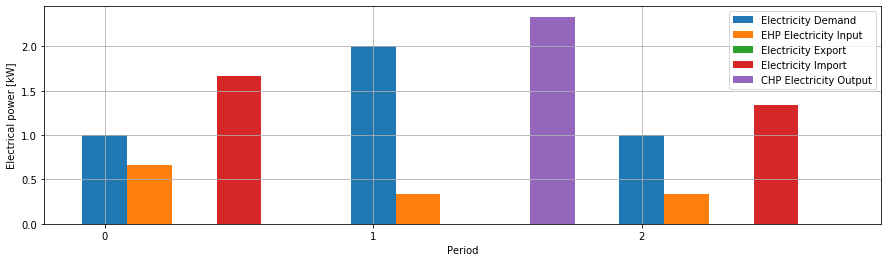

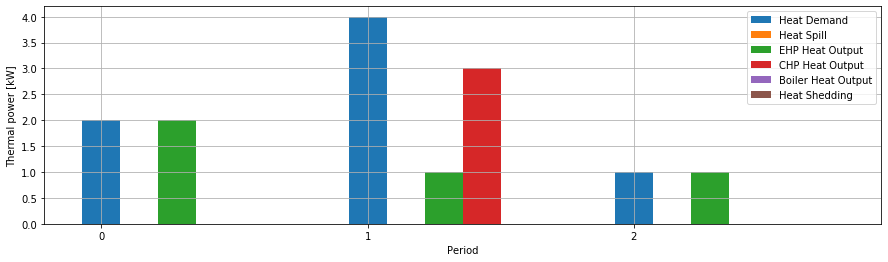

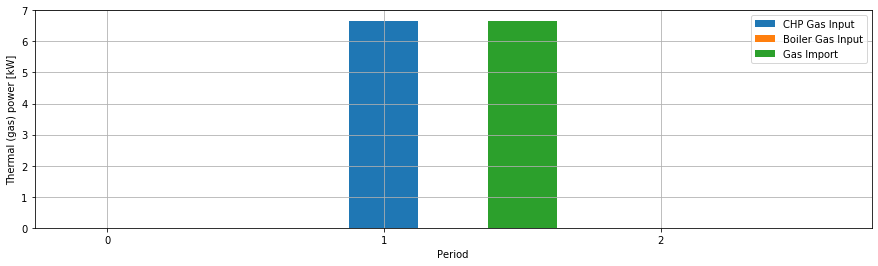

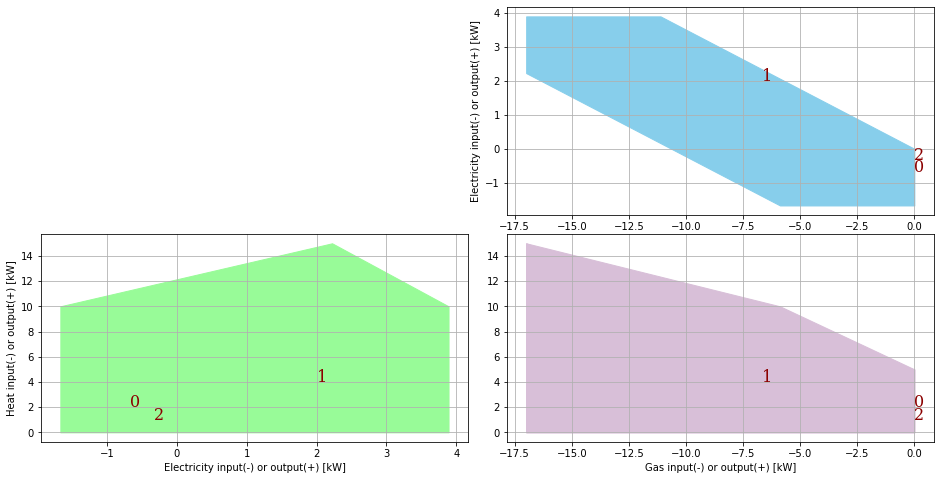

Costs: 0.43 [£]


In [32]:
# Setting pyomo model and number of periods to optimise
model = pyo.ConcreteModel()
model.Set_Periods = range(3)
model.dt = 1

# Demands
model.Electricity_Demand = [1, 2, 1]  # [kW]
model.Heat_Demand = [2, 4, 1]  # [kW]

# DER
model.Boiler_Heat_Capacity = 5  # [kW]
model.Boiler_Heat_Efficiency = 0.85  # [pu]

model.EHP_Heat_Capacity = 5  # [kW]
model.EHP_Heat_Efficiency = 3  # [pu]

model.CHP_Heat_Capacity = 5  # [kW]
model.CHP_Electricity_Efficiency = 0.35  # [pu]
model.CHP_Heat_Efficiency = 0.45  # [pu]

# Prices and penalties
model.Electricity_Import_Price = [0.01, 0.5, 0.01]  # [£/kWh]
model.Electricity_Export_Price = [0.01, 0.01, 0.01]  # [£/kWh]
model.Gas_Import_Price = [0.06, 0.06, 0.06]  # [£/kWh]

model.Heat_Spill_Penalty = [0, 0, 0]  # [£/kWh]
model.Heat_Shedding_Penalty = [1000, 1000, 1000]  # [£/kWh]

# Building and solving model
results = build_MES_Cogeneration_Model(model)

# Bar charts
Fig_Names_E = ['Electricity_Demand', 'EHP_Electricity_Input', 'Electricity_Export',
               'Electricity_Import', 'CHP_Electricity_Output']
plot_MES(model, Fig_Names_E, 'Electrical power [kW]')
Fig_Names_H = ['Heat_Demand', 'Heat_Spill', 'EHP_Heat_Output',
               'CHP_Heat_Output', 'Boiler_Heat_Output', 'Heat_Shedding']
plot_MES(model, Fig_Names_H, 'Thermal power [kW]')

Fig_Names_G = ['CHP_Gas_Input', 'Boiler_Gas_Input', 'Gas_Import']
plot_MES(model, Fig_Names_G, 'Thermal (gas) power [kW]')

# Sankey diagram
sankey_MES_Cogeneration(model)

# Flexibility areas
flexibility_MES_Cogeneration(model)

print('Costs: %.2f'%model.Objective_Function.expr(), '[£]')

[Back to top](#Multi-energy-generation-systems---Example-with-cogeneration)